In [92]:
from pathlib import Path
import pickle
import sys

sys.path.append('/data/condor_shared/users/ssued/RNOGCnn')
import utils

data_path = Path("data/")
event_path = data_path / 'eventbatch_k'

eventbatch = utils.obtain_evb('eventbatch.pkl')

In [93]:
torch.cuda.is_available()
torch.__version__

'2.5.1+cu124'

In [94]:
# Split the eventbatch_k into 75% training and 25% testing
# Calculate the split index
split_index = int(len(eventbatch) * 0.75)

# Split the eventbatch_k into 75% training and 25% testing
train_eventbatch = dict(list(eventbatch.items())[:split_index])
test_eventbatch = dict(list(eventbatch.items())[split_index:])

print(f'Size of train_eventbatch = {len(train_eventbatch.keys())}')
print(f'Size of test_eventbatch = {len(test_eventbatch.keys())}')

Size of train_eventbatch = 52912
Size of test_eventbatch = 17638


For really small n-event testing

In [95]:
# train_eventbatch = dict(list(eventbatch.items())[:3])
# test_eventbatch = dict(list(eventbatch.items())[3:4])

In [96]:
# Prepare data into DataLoader
from torch.utils.data import DataLoader

train_data = utils.EventtoData(train_eventbatch,normalize=False)
test_data = utils.EventtoData(test_eventbatch,normalize=False)

BATCH_SIZE = 32 # Small batch size just to test batch size feature

train_data_loader = DataLoader(dataset = train_data, batch_size = BATCH_SIZE, shuffle=False)
test_data_loader = DataLoader(dataset = test_data, batch_size = BATCH_SIZE, shuffle = False)

In [97]:
from torch import nn
# Let there be light!
    
class RNOG_CNN_alpha_1(nn.Module):

    def __init__(self,input_shape: int, hidden_units: int, output_shape: int, batch_size: int, num_epochs: int, train_n: int, test_n: int):
        super().__init__()
        #KERNEL_HEIGHT = 4
        #KERNEL_WIDTH = 25
        #KERNEL_SIZE = (KERNEL_HEIGHT,KERNEL_WIDTH)
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.train_n = train_n
        self.test_n = test_n

        self.conv_block_1=nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=output_shape,
                      kernel_size=(4,25),
                      stride=1))
            # nn.Conv2d(in_channels=hidden_units,
            #           out_channels=output_shape,
            #           kernel_size=(2,14),
            #           stride=1),)

    def forward(self,x):
        x = self.conv_block_1(x)
        return x

In [98]:
# from torchinfo import summary
# model_test = RNOG_CNN_alpha_1(1,10,1)

# summary(model_test, input_size=[1, 1, 4, 25]) # do a test pass through of an example input size

In [99]:
# Setup device agnostic code
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [100]:
import numpy as np

_,train_snr = next(iter(train_data_loader))
_,test_snr = next(iter(test_data_loader))


print(torch.mean(train_snr))
print(torch.mean(test_snr))

tensor(3.5714)
tensor(3.3798)


In [101]:
# Train_step function:

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss
    #train_loss = 0
    train_loss_arr = []
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)
        y = y.view_as(y_pred)

        # 2. Calculate and accumulate loss
        loss = loss_fn(y_pred, y)
        #train_loss += loss.item()
        train_loss_arr.append(loss)

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Adjust metrics to get average loss per batch
    #train_loss = train_loss / len(dataloader)
    train_loss = sum(train_loss_arr)/len(train_loss_arr)

    return train_loss

In [102]:
# Test step function:

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test values
    #test_loss = 0
    test_loss_arr = []

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            y_pred = model(X)
            y = y.view_as(y_pred)

            # 2. Calculate and accumulate loss
            loss = loss_fn(y_pred, y)
            #test_loss += loss.item()
            test_loss_arr.append(loss)

            #print(f'For batch: {batch} || in test_loss, max test loss: {max(test_loss_arr)}, arr_len: {len(test_loss_arr)}') # For debugging        

    # Adjust metrics to get average loss per batch 
    #test_loss = test_loss / len(dataloader)
    test_loss = np.average(test_loss_arr)

    return test_loss

In [103]:
# Train function (Combines both steps)

from torch.optim.lr_scheduler import ExponentialLR
from tqdm.auto import tqdm

# Set number of epochs
NUM_EPOCHS = 5000

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          scheduler: torch.optim.lr_scheduler.LRScheduler,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          pause = False,
          stop_at_min = 10):
    
    global NUM_EPOCHS   

    # 2. Create empty results dictionary
    results = {"train_loss": [],
               "test_loss": [],
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss = train_step(model=model,
                                dataloader=train_dataloader,
                                loss_fn=loss_fn,
                                optimizer=optimizer)
        test_loss = test_step(model=model,
                              dataloader=test_dataloader,
                              loss_fn=loss_fn)
        if scheduler:
            scheduler.step()

        # 4. Print out what's happening
        if epoch % 10 == 0:
            print(
                f"Epoch: {epoch} | "
                f"train_loss: {train_loss:.10f} | "
                f"test_loss: {test_loss:.10f} | "
            )
            if scheduler:
                print(f"learning_rate: {scheduler.get_last_lr():.10f}")


        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)

        if pause:
            # Wait for keypress to break the loop
            if (epoch % 10)== 0 and epoch > 0:
                try:
                    if input("Press Enter to continue training or type 'stop' to end: ").strip().lower() == 'stop':
                        NUM_EPOCHS = epoch + 1
                        break
                except KeyboardInterrupt:
                    print("Training interrupted by user.")
                    NUM_EPOCHS = epoch + 1
                    break

        if stop_at_min:
            if len(results['test_loss']) > stop_at_min:
                # Count increases and decreases in the last 10 epochs
                increases = sum(results['test_loss'][-i] > results['test_loss'][-i-1] for i in range(1, stop_at_min+1))
                decreases = stop_at_min - increases
                # Check if there are more increases than decreases
                if increases > decreases:
                    NUM_EPOCHS = epoch + 1
                    print(f"Stopping early at epoch {epoch + 1} due to more increases than decreases in test loss over the last 10 epochs.")
                    break

    # 6. Return the filled results at the end of the epochs
    return results

In [104]:
# Create model_1
model_1 = RNOG_CNN_alpha_1(input_shape=1, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=1,
                  batch_size=BATCH_SIZE,
                  num_epochs=NUM_EPOCHS,
                  train_n = len(train_eventbatch.keys()),
                  test_n = len(test_eventbatch.keys())
                  )

# Setup loss function and optimizer
loss_fn = nn.MSELoss()
#loss_fn = nn.HuberLoss(delta=0.01)
#loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_1.parameters())
scheduler = False#ExponentialLR(optimizer, gamma=0.9)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0 
model_1_results = train(model=model_1, 
                        train_dataloader=train_data_loader,
                        test_dataloader=test_data_loader,
                        optimizer=optimizer,
                        scheduler=scheduler,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS,
                        pause=False,
                        #stop_at_min=int(NUM_EPOCHS/100)
                        )
    
# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 0 | train_loss: 4.3995904922 | test_loss: 3.2619214058 | 
Epoch: 10 | train_loss: 4.2476587296 | test_loss: 3.2210316658 | 
Epoch: 20 | train_loss: 4.1891160011 | test_loss: 3.1870174408 | 
Epoch: 30 | train_loss: 4.1366410255 | test_loss: 3.1548736095 | 
Epoch: 40 | train_loss: 4.0878648758 | test_loss: 3.1236279011 | 
Epoch: 50 | train_loss: 4.0418066978 | test_loss: 3.0931699276 | 


KeyboardInterrupt: 

10000


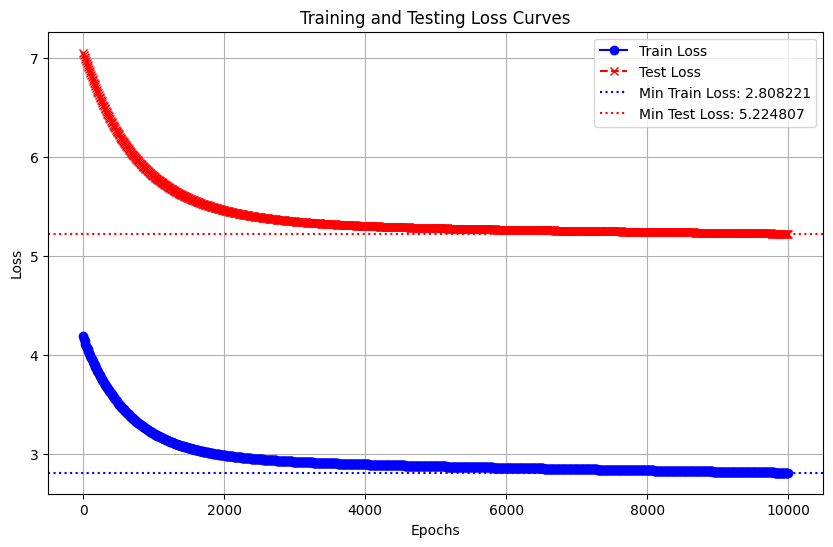

In [ ]:
import matplotlib.pyplot as plt

print(NUM_EPOCHS)

# Plot loss curves with improved aesthetics:
epochs = np.arange(NUM_EPOCHS)
train_loss = model_1_results['train_loss']
test_loss = model_1_results['test_loss']

plt.figure(figsize=(10, 6))
plt.plot(epochs[3::10], train_loss[3::10], label='Train Loss', color='blue', linestyle='-', marker='o')
plt.plot(epochs[3::10], test_loss[3::10], label='Test Loss', color='red', linestyle='--', marker='x')

# Plot minimum loss horizontal lines
min_train_loss = min(train_loss)
min_test_loss = min(test_loss)
plt.axhline(y=min_train_loss, color='blue', linestyle=':', label=f'Min Train Loss: {min_train_loss:.6f}')
plt.axhline(y=min_test_loss, color='red', linestyle=':', label=f'Min Test Loss: {min_test_loss:.6f}')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

For batch size 250: avg mse: 0.22745657986120021
For batch size 50: avg mse: 1.0588526575854587

In [ ]:
def make_predictions(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, device: torch.device = 'cpu', plot: bool = False, verbose: bool = False):
    """
    Make predictions using a trained PyTorch model on a given DataLoader.

    Args:
        model (torch.nn.Module): The trained PyTorch model to use for predictions.
        dataloader (torch.utils.data.DataLoader): DataLoader containing the data to predict on.
        device (torch.device, optional): The device to run the model on (default 'cpu').
        plot (bool, optional): Whether to plot the predicted vs true SNR values (default is False).
        verbose (bool, optional): Whether to print detailed prediction information, including MSE for each sample (default is False).

    Returns:
        list: A list of tuples containing predicted and true SNR values for each sample in the DataLoader.
    """

    predictions = []
    model.eval()
    with torch.inference_mode():
        for data, snr in dataloader:
            data = data.to(device)
            pred = model(data)
            predictions.append((pred.cpu().item(), snr.cpu().item()))

    if verbose:
        print("First 20 predictions (Predicted SNR, True SNR):")
        avg_mse = 0
        for i, (pred, true) in enumerate(predictions):
            print(f"Sample {i + 1}: Predicted = {pred:.16f}, True = {true:.16f}")
            mse = (pred-true)**2
            print(f'MSE: {mse}')
            avg_mse+=mse
        print(f'Average MSE: {avg_mse/20}')
            


    if plot:
        pred_values, true_values = zip(*predictions)
        differences = [true - pred for true, pred in predictions]

        plt.figure(figsize=(12, 6))
        plt.hist(differences, bins=np.arange(-3, 3, 0.1), edgecolor='black', alpha=0.7)
        #plt.hist2d(true_values,pred_values,bins=[np.linspace(2,5,10),np.linspace(2,5,10)])
        plt.xlabel('Difference (True SNR - Predicted SNR)', fontsize=14)
        plt.ylabel('Frequency', fontsize=14)
        plt.title('Histogram of Differences Between True and Predicted SNR', fontsize=16)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.show()

    return predictions

In [ ]:
model_1.state_dict()

OrderedDict([('conv_block_1.0.weight',
              tensor([[[[-8.1881e+00, -1.0143e+00,  9.5428e-01,  4.3074e+00,  3.0464e+00,
                          2.2706e+00,  1.8296e+00,  3.1516e+00,  3.6898e+00,  3.6405e+00,
                          1.4870e+00,  3.6354e+00,  2.9685e+00,  2.0609e+00,  8.3494e-01,
                         -1.7400e+00, -2.4573e-01,  2.9179e-01, -3.7873e-01,  4.5649e-01,
                         -2.3009e+00, -3.2735e+00, -1.0145e+01, -1.1258e+01, -8.1125e+00],
                        [-8.5045e+00, -1.2072e+00,  7.2550e-01,  3.8189e+00,  2.9866e+00,
                          2.0390e+00,  1.8164e+00,  3.1954e+00,  3.8255e+00,  3.2774e+00,
                          1.5388e+00,  3.4646e+00,  2.3988e+00,  1.9736e+00,  6.5094e-01,
                         -1.5306e+00, -4.2184e-01,  7.9827e-04, -1.8979e-01,  2.4008e-01,
                         -2.6852e+00, -3.5163e+00, -1.0477e+01, -1.1054e+01, -7.9893e+00],
                        [-8.4194e+00, -9.7057e-01,  4.7532e

Should stay commented to avoid any issues:

In [ ]:
from pathlib import Path
from datetime import datetime

# Create model directory path
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

# Create model save path
MODEL_NAME=f'RNOG_alpha_model_b:{model_1.batch_size}_e:{model_1.num_epochs}_tn:{model_1.train_n}'
MODEL_SAVE_PATH=MODEL_PATH/MODEL_NAME

print(f'Saving model to: {MODEL_SAVE_PATH}')
torch.save(obj=model_1.state_dict(),f=MODEL_SAVE_PATH)
# Add last save date and time
last_save_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Model last saved on: {last_save_time}")

Saving model to: models/RNOG_alpha_model_b:32_e:10000_tn:20334
Model last saved on: 2025-04-07 08:15:31


For Loading Models

In [ ]:
# import torch
# import pickle
# import matplotlib.pyplot as plt
# import numpy as np
# from torch import nn

# loaded_model = RNOG_CNN_alpha_1(input_shape=1, # number of color channels (3 for RGB) 
#                   hidden_units=10, 
#                   output_shape=1)

# loaded_model.load_state_dict(torch.load('/data/condor_shared/users/ssued/RNOGCnn/CNN/models/RNOG_alpha_model_3.pth'))


/tmp/ipykernel_2252580/493106630.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load('/data/condor_shared/users/ssued/RNOGCnn/CNN/mo

<All keys matched successfully>

In [ ]:
import random
import sys
sys.path.append('/data/condor_shared/users/ssued/RNOGCnn')
import utils
from torch.utils.data import DataLoader

device='cpu'

eventbatch = utils.obtain_evb('eventbatch.pkl')
# Select 20 random events from eventbatch
random_events = dict(random.choices(list(eventbatch.items()), k=100))

random_data = utils.EventtoData(random_events)

random_dataloader = DataLoader(random_data,1,False)

model_1.eval()
loss_fn = nn.MSELoss()

# with torch.inference_mode():
#     for i, (data, snr) in enumerate(random_dataloader):
#         data, snr = data.to(device), snr.to(device)
#         pred = loaded_model(data)
#         loss = loss_fn(pred, snr)
#         print(f"Data Point {i + 1}: Loss = {loss.item():.6f}")

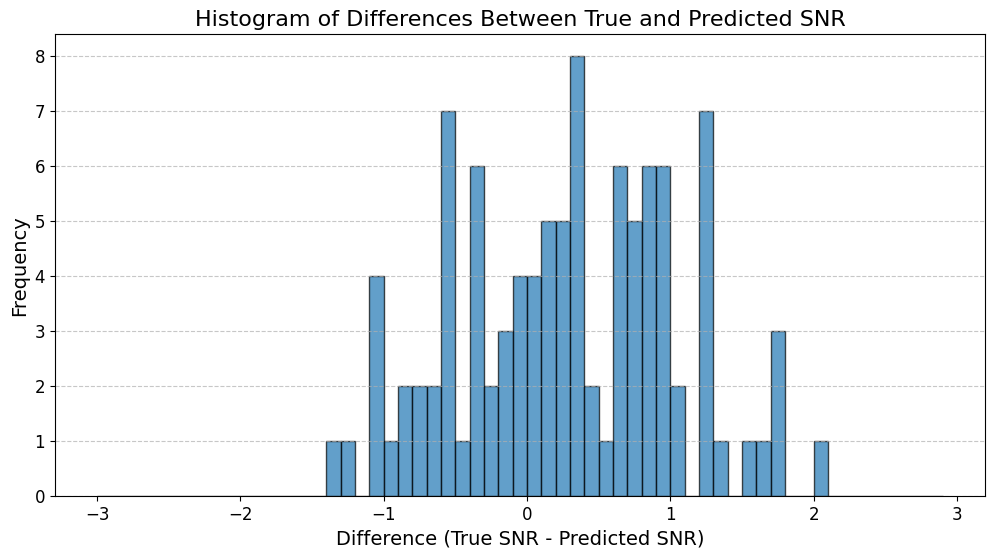

In [ ]:
make_predictions(model_1, random_dataloader, device=device, plot=True,verbose=False);